# Sneak peak case - Climate sentiment

## To-do

1. Perform emotion analysis on snippets. +
2. Find public surveys of people's oppinion about climate change and compare to snippet sentiments.
3. Check whether the TV-stations are pro-republican or pro-democrat and compare the differences.
4. Write down 5-10 concrete scenarios where this information would benefit the government. (e.g. hesitation of having children, economy, politics, ideology)
5. Find out what were the events that caused massive interactions. +

## 1. Data import and cleaning

In [8]:
# pip install wordcloud

In [9]:
# pip install text2emotion

In [10]:
# imports
import pandas as pd
import ast
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import re
import text2emotion as te
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [11]:
# importing all the csv files

# getting the names of all files
names = [f for f in listdir('data') if isfile(join('data', f))]  

dataframes = []

# reading them all in and adding them to a list
for file_name in names:
    file = open('data/'+ file_name, encoding="cp437")
    temp_df = pd.read_csv(file)
    dataframes.append(temp_df)

In [12]:
# checking if all the dataframes have the same number of columns, as I know for certain that one doesn't

df_to_delete = []

# getting the index of the messed up dataframes, deleting them
for i in range(len(dataframes)):
    if(dataframes[i].shape[1] != 7):
        df_to_delete.append(i)
for i in df_to_delete:
    del(dataframes[i])

In [13]:
# transforming the MatchDateTime column to month, day, year, and part of day

for df in dataframes:
    df["month"] = df.apply(lambda x: int(x["MatchDateTime"].split('/')[0]), axis=1)
    df["day"] = df.apply(lambda x: int(x["MatchDateTime"].split('/')[1]), axis=1)
    df["year"] = df.apply(lambda x: int(x["MatchDateTime"].split('/')[2].split(' ')[0]), axis=1)
    df["part of day"] = df.apply(lambda x: int(x["MatchDateTime"].split('/')[2].split(' ')[1].split(':')[0]), axis=1)
    df["part of day"] = df["part of day"].apply(lambda x: "morning" if(x >= 5 and x <= 12) else 
                                                                      ("afternoon" if (x >= 13 and x <= 17) else 
                                                                     ("evening" if(x >= 18 and x <= 21) else 
                                                                     "night")))
    # setting the index of the dataframe to be year, month, day so it is easier to plot and organize sentiment time wise, it is optional however
    df.set_index(['year', 'month', 'day'], inplace=True)
    # dropping the columns that aren't necessary
    df.drop(['IAPreviewThumb', 'MatchDateTime'], axis=1, inplace=True)
    # renaming the columns
    df.columns = ['url', 'station', 'show', 'showID', 'snippet',
       'part of day']

In [14]:
# combining all the dataframes into one df
# and we still have the cleaned dataframes organized in dataframes list

df = pd.concat(dataframes)

# sorting the final dataframe by year, month, day
df.sort_index(inplace=True)

## 2. Data visualisation

In [15]:
df_copy = df.reset_index()

# Create a df with unique combinations of year and month
df_count = df_copy[['year','month']].drop_duplicates()
df_count = df_count.sort_values(['year', 'month'])
stations = df['station'].drop_duplicates()

# Assign number of snippets for each TV station and month
for s in stations:
    df_count[s] = 0
    for i, row in df_count.iterrows():
        df_count.at[i, s] = len(df_copy[(df_copy['year'] == row['year']) & (df_copy['month'] == row['month']) & (df_copy['station'] == s)])

# Combine to date for plots
df_count['month'] = df_count['month'].astype(str)
df_count['month'] = df_count['month'].apply(lambda x: x.zfill(2))

df_count['date'] = (df_count['year']).astype(str) +'-'+ (df_count['month']).astype(str)

df_count

,year,month,FOXNEWS,MSNBC,CNN,BBCNEWS,date
0,2009,07,422,90,170,0,2009-07
682,2009,08,143,133,65,0,2009-08
1023,2009,09,264,144,19,0,2009-09
1450,2009,10,418,203,0,0,2009-10
2071,2009,11,483,123,134,0,2009-11
...,...,...,...,...,...,...,...
82535,2019,09,810,937,701,1322,2019-09
86305,2019,10,230,217,216,664,2019-10
87632,2019,11,272,398,328,1362,2019-11
89992,2019,12,219,317,374,2103,2019-12


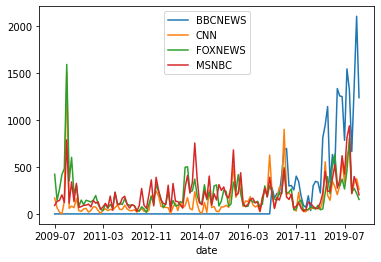

In [16]:
ax = plt.gca()

plt.rcParams["figure.figsize"] = (16,8)

df_count.plot(x='date', y="BBCNEWS",ax=ax) #, title='Interactions regarding climate topics across the time')
df_count.plot(x='date', y="CNN",ax=ax)
df_count.plot(x='date', y="FOXNEWS",ax=ax)
df_count.plot(x='date', y="MSNBC",ax=ax)

plt.show()

In [17]:
# Create a df with unique parts of the day
df_day_parts = df_copy[['part of day']].drop_duplicates()
df_day_parts = df_day_parts.sort_values(['part of day'])
stations = df['station'].drop_duplicates()

# Assign number of snippets for each TV station and part of the day
for s in stations:
    df_day_parts[s] = 0
    for i, row in df_day_parts.iterrows():
        df_day_parts.at[i, s] = len(df_copy[(df_copy['part of day'] == row['part of day']) & (df_copy['station'] == s)])

#works only on pandas >1.1.0
ordering_dict = {'morning': 0, 'afternoon': 1, 'evening': 2, 'night': 3}
df_day_parts = df_day_parts.sort_values(by=['part of day'], key = lambda x: x.map(ordering_dict))

df_day_parts

,part of day,FOXNEWS,MSNBC,CNN,BBCNEWS
7,morning,9037,6898,6583,6828
3,afternoon,3818,5863,4564,4318
1,evening,4121,5367,3250,3975
0,night,8889,8301,4907,8139


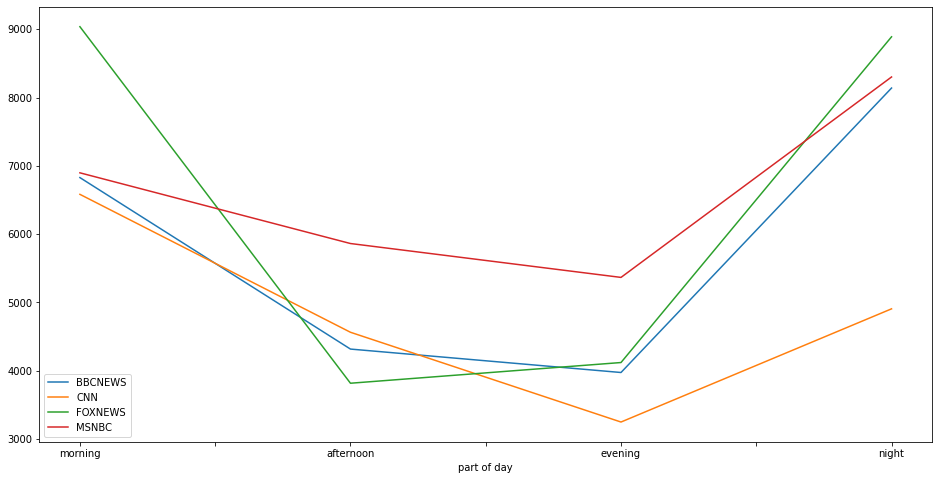

In [10]:
ax = plt.gca()

df_day_parts.plot(x='part of day', y="BBCNEWS",ax=ax) #, title='Absolute distribution of interactions during the day')
df_day_parts.plot(x='part of day', y="CNN",ax=ax)
df_day_parts.plot(x='part of day', y="FOXNEWS",ax=ax)
df_day_parts.plot(x='part of day', y="MSNBC",ax=ax)

plt.show()

In [20]:
# Calculate relative number of interactions per part of the day
df_day_parts_relative = df_day_parts
list_of_sums = []
for s in stations:
    station_sum = df_day_parts_relative[s].sum()
    list_of_sums.append(station_sum)
    df_day_parts_relative[s] = df_day_parts_relative[s]/station_sum

print(list_of_sums)
df_day_parts_relative

[25865, 26429, 19304, 23260]


,part of day,FOXNEWS,MSNBC,CNN,BBCNEWS
7,morning,0.349391,0.261001,0.341017,0.293551
3,afternoon,0.147613,0.221840,0.236428,0.185641
1,evening,0.159327,0.203072,0.168359,0.170894
0,night,0.343669,0.314087,0.254196,0.349914


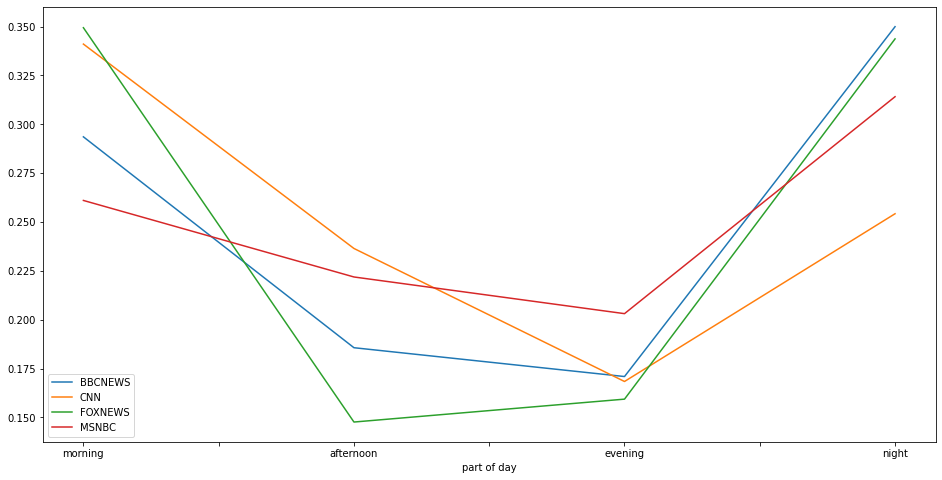

In [21]:
ax = plt.gca()

df_day_parts_relative.plot(x='part of day', y="BBCNEWS",ax=ax) #, title='Relative distribution of interactions during the day')
df_day_parts_relative.plot(x='part of day', y="CNN",ax=ax)
df_day_parts_relative.plot(x='part of day', y="FOXNEWS",ax=ax)
df_day_parts_relative.plot(x='part of day', y="MSNBC",ax=ax)

plt.show()

## 3. Sentiment Analysis

In [23]:
wordnet_lemmatizer = WordNetLemmatizer()
stopwords = stopwords.words('english')

## 3.1. Polarity and emotions calculation

In [24]:
# remove all the punctuations
df['snippet'] = df['snippet'].apply(lambda x: re.sub(r'[.,"\'%\[\]\-?:!;]', '', x))

# remove stopwords
df['snippet'] = df['snippet'].apply(lambda x: ' '.join([word for word in x.split(' ') if word not in (stopwords)]))

# lemmatization
df['snippet'] = df['snippet'].apply(lambda x: ' '.join([wordnet_lemmatizer.lemmatize(word) for word in x.split(' ')]))

# calculate the polarity
df['polarity'] = df['snippet'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [25]:
# calculation of emotions

"""import multiprocessing as mp
with mp.Pool(mp.cpu_count()) as pool:
    df['emotions'] = pool.map(te.get_emotion, df['snippet'])"""
    
# import the calculated data set
    
df = pd.read_csv('data/df_with_emotions/df-with-emotions.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df['date']=pd.to_datetime(df[['year','month','day']])
df.set_index('date', inplace=True)

# convert the emotions keys to a corresponding emotion column
df['happy'] = df['emotions'].apply(lambda x: ast.literal_eval(x)['Happy'])
df['angry'] = df['emotions'].apply(lambda x: ast.literal_eval(x)['Angry'])
df['surprise'] = df['emotions'].apply(lambda x: ast.literal_eval(x)['Surprise'])
df['sad'] = df['emotions'].apply(lambda x: ast.literal_eval(x)['Sad'])
df['fear'] = df['emotions'].apply(lambda x: ast.literal_eval(x)['Fear'])
df.drop('emotions', axis=1, inplace=True)

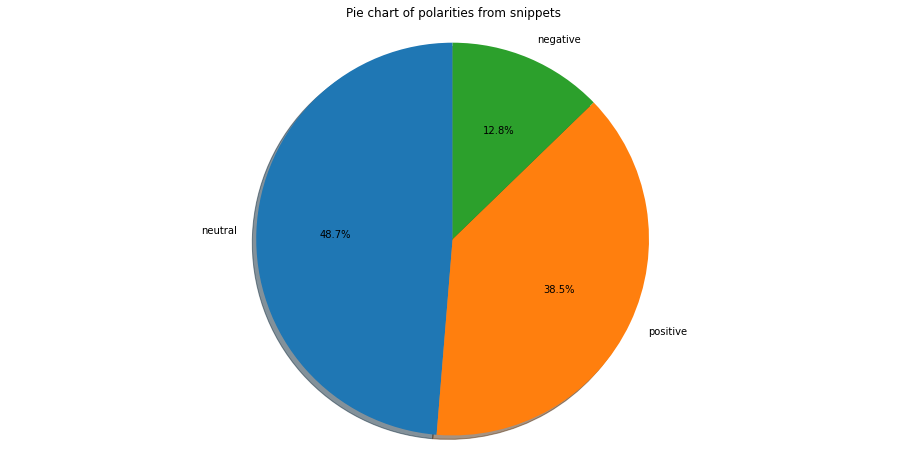

In [26]:
# plot polarities 

sentiment = []
for x in df['polarity']:
    if(x >= -0.1 and x <= 0.1):
        sentiment.append("neutral")
    elif(x > 0.1):
        sentiment.append("positive")
    else:
        sentiment.append("negative")

status_d=Counter(sentiment)

key_list = list(status_d.keys())
val_list = list(status_d.values())

fig1, ax1 = plt.subplots()
ax1.pie(val_list, labels=key_list, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Pie chart of polarities from snippets")

plt.show()

## 3.2. Word clouds

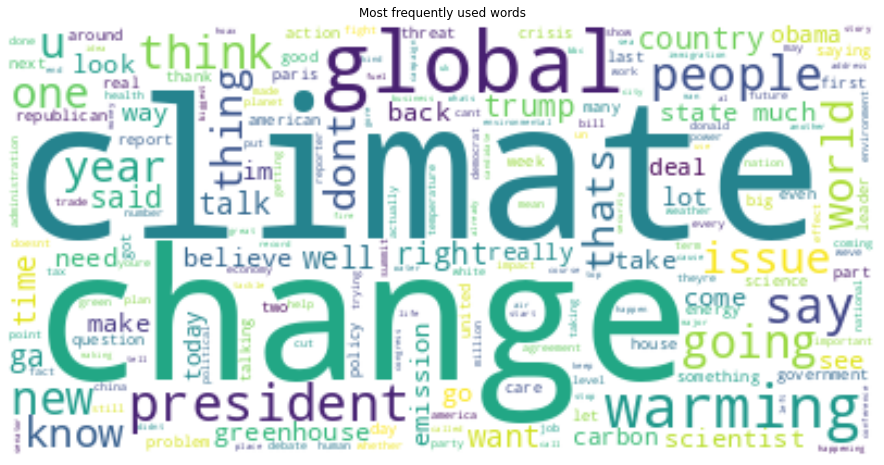

In [27]:
# calculate wordCloud for all snippets

snippets_combined = ' '.join([item for item in df['snippet']])

word_cloud = WordCloud(collocations = False, background_color = 'white').generate(snippets_combined)
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.title('Most frequently used words')
plt.axis("off")
plt.show()

In [28]:
# find the 20 most frequent words in the snippets so the events details can be easier to spot
c = Counter(snippets_combined.split(" "))
common_20 = c.most_common(25)

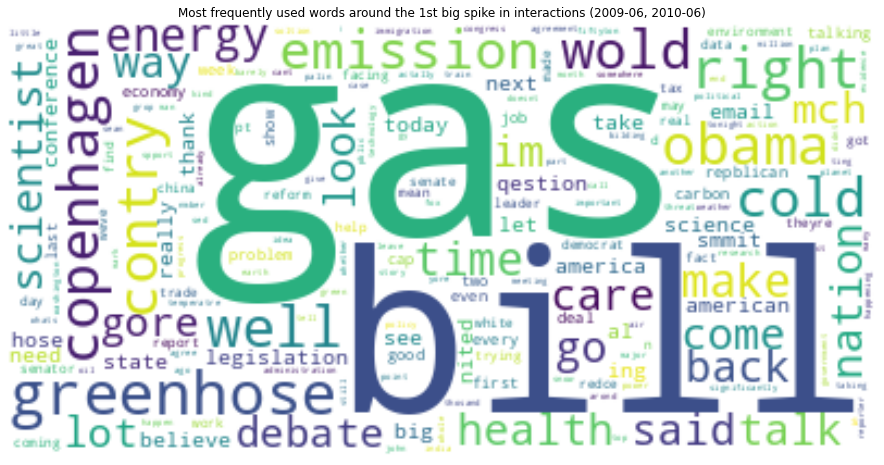

In [29]:
# 1st event (June 2009 - June 2010)

snippets_combined = ' '.join([item for item in df.loc[(df.index >= '2009-06-01') & (df.index < '2010-06-30')]['snippet']])

for word in common_20:
    snippets_combined = re.sub(word[0], "" , snippets_combined)

word_cloud = WordCloud(collocations = False, background_color = 'white').generate(snippets_combined)
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.title('Most frequently used words around the 1st big spike in interactions (2009-06, 2010-06)')
plt.axis("off")
plt.show()                           

Things that caused the interaction spike in 2010:
- Climate Change and Greenhouse Gas Reduction Act 2010
- The UN Conference on Climate Change in Copenhagen
- Climate change bill 2010

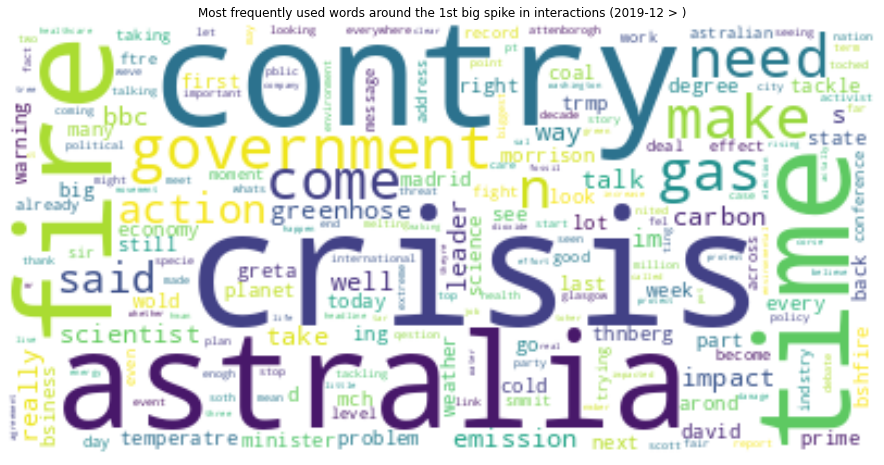

In [30]:
# 2nd event (March 2019 - end)

snippets_combined = ' '.join([item for item in df.loc[(df.index >= '2019-12-01')]['snippet']])

for word in common_20:
    snippets_combined = re.sub(word[0], "" , snippets_combined)

word_cloud = WordCloud(collocations = False, background_color = 'white').generate(snippets_combined)
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.title('Most frequently used words around the 1st big spike in interactions (2019-12 > )')
plt.axis("off")
plt.show()         

Things that caused the interaction spike in 2019/2020:
- 2019–20 Australian bushfire season

## 3.3. Trends and patterns

In [31]:
# create a datetime index to group things by month

df.reset_index(inplace=True)
df['date']=pd.to_datetime(df[['year','month','day']])
df.set_index('date', inplace=True)
# df.drop(['year', 'month', 'day'], axis=1,  inplace=True)

Text(0.5, 1.0, 'Mean polarity throughout the years')

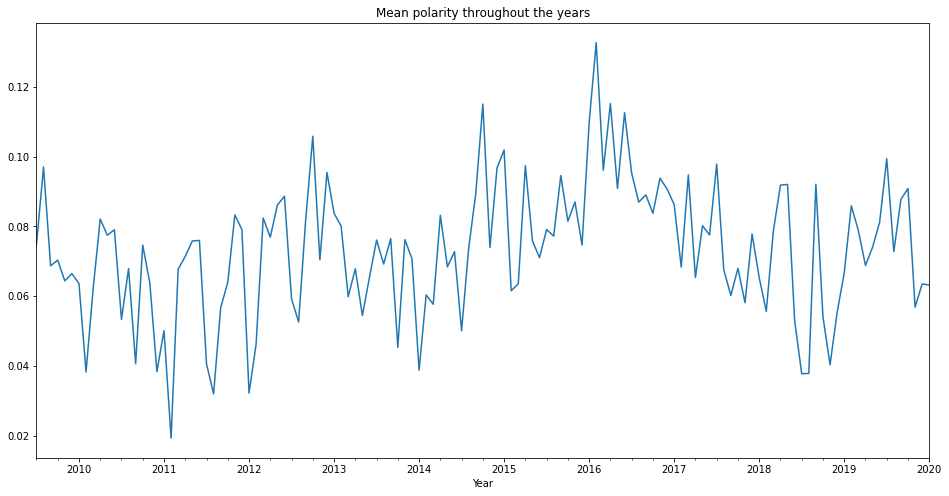

In [32]:
# mean polarity throughout the years
df.groupby(pd.Grouper(freq='M'))['polarity'].mean().plot()
plt.xlabel('Year')
plt.title('Mean polarity throughout the years')

<AxesSubplot:xlabel='month'>

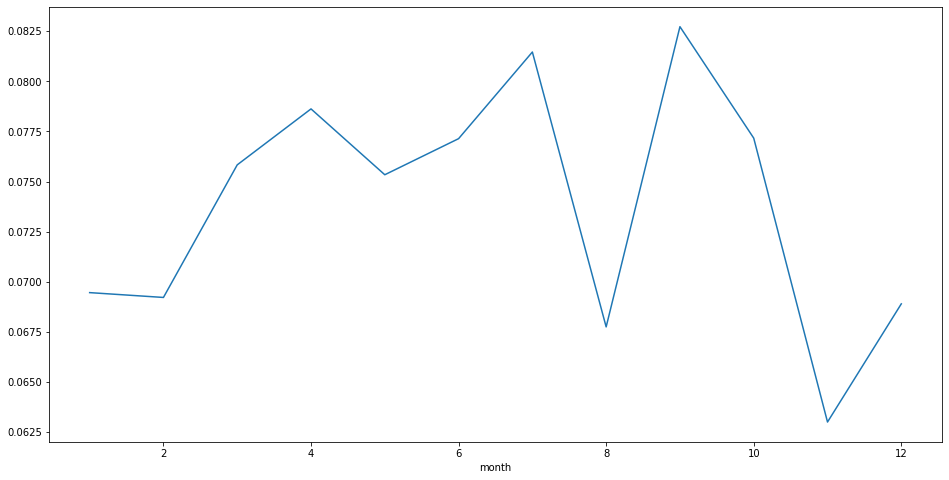

In [23]:
# sentiment trends
df.groupby('month').mean()['polarity'].plot()
plt.xlabel('Month')
plt.title('Mean polarity by months of the year')

Text(0.5, 1.0, 'Number of snippets over time')

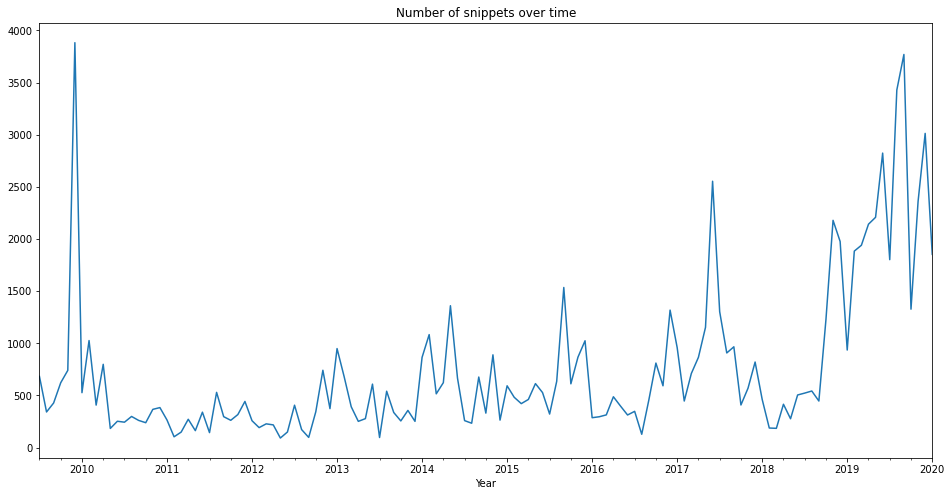

In [33]:
# snippets over time
df.groupby(pd.Grouper(freq='M')).count()['snippet'].plot()
plt.xlabel('Year')
plt.title('Number of snippets over time')

Text(0.5, 1.0, 'Mean emotions over time')

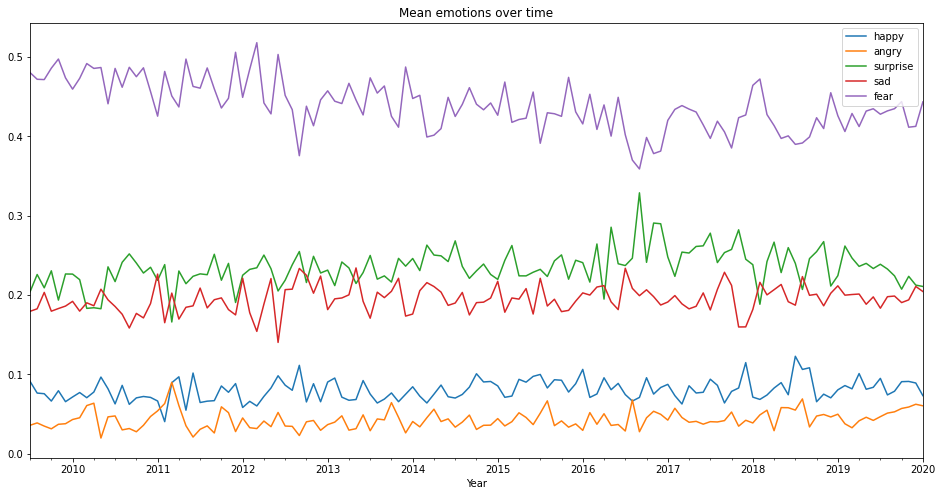

In [34]:
# plot emotions over time 
df.groupby(pd.Grouper(freq='M')).mean()[['happy', 'angry', 'surprise', 'sad', 'fear']].plot()
plt.xlabel('Year')
plt.title('Mean emotions over time')

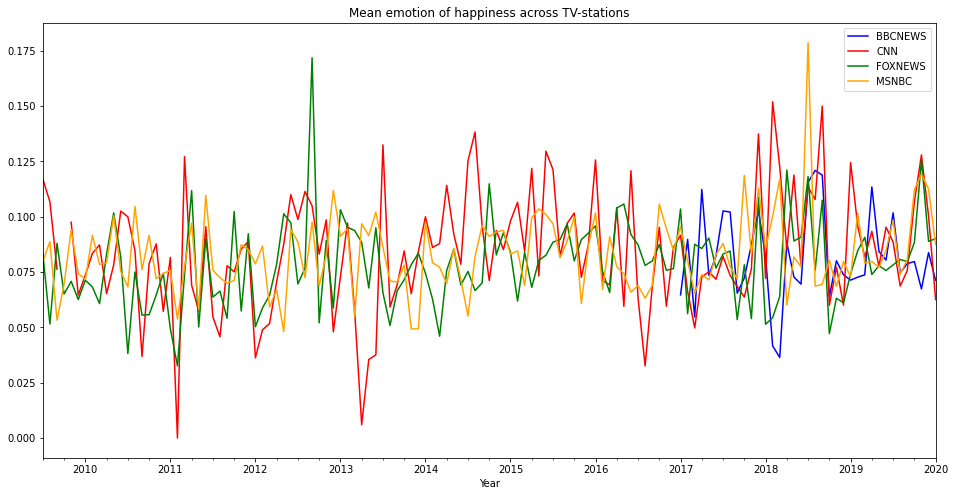

In [35]:
# happy
df[df['station']=="BBCNEWS"].groupby(pd.Grouper(freq='M')).mean()['happy'].plot(label="BBCNEWS", color="blue")
df[df['station']=="CNN"].groupby(pd.Grouper(freq='M')).mean()['happy'].plot(label="CNN", color="red")
df[df['station']=="FOXNEWS"].groupby(pd.Grouper(freq='M')).mean()['happy'].plot(label="FOXNEWS", color="green")
df[df['station']=="MSNBC"].groupby(pd.Grouper(freq='M')).mean()['happy'].plot(label="MSNBC", color="orange")
plt.title("Mean emotion of happiness across TV-stations")
plt.xlabel('Year')
plt.legend()

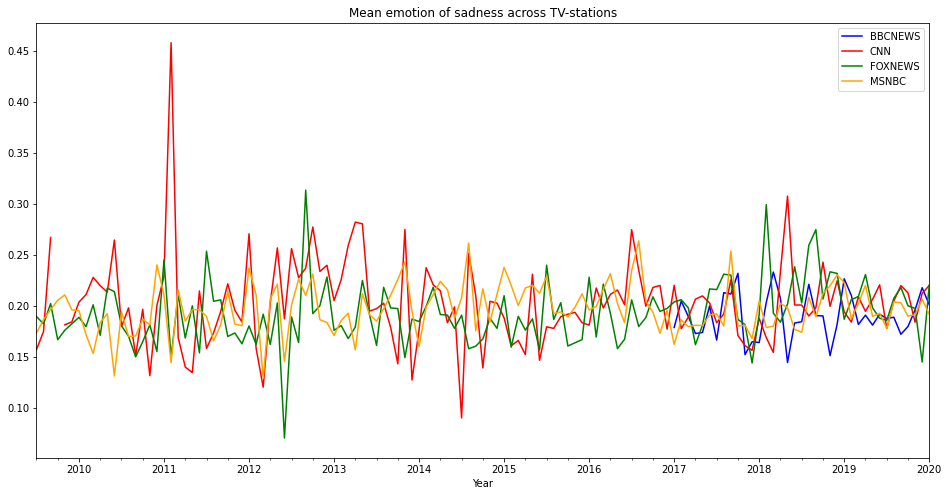

In [36]:
# sad
df[df['station']=="BBCNEWS"].groupby(pd.Grouper(freq='M')).mean()['sad'].plot(label="BBCNEWS", color="blue")
df[df['station']=="CNN"].groupby(pd.Grouper(freq='M')).mean()['sad'].plot(label="CNN", color="red")
df[df['station']=="FOXNEWS"].groupby(pd.Grouper(freq='M')).mean()['sad'].plot(label="FOXNEWS", color="green")
df[df['station']=="MSNBC"].groupby(pd.Grouper(freq='M')).mean()['sad'].plot(label="MSNBC", color="orange")
plt.title("Mean emotion of sadness across TV-stations")
plt.xlabel('Year')
plt.legend()

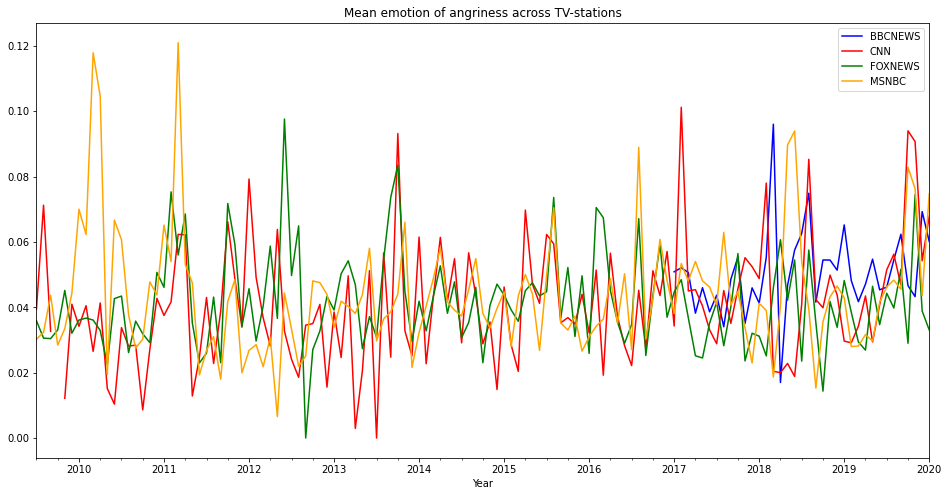

In [37]:
# angry
df[df['station']=="BBCNEWS"].groupby(pd.Grouper(freq='M')).mean()['angry'].plot(label="BBCNEWS", color="blue")
df[df['station']=="CNN"].groupby(pd.Grouper(freq='M')).mean()['angry'].plot(label="CNN", color="red")
df[df['station']=="FOXNEWS"].groupby(pd.Grouper(freq='M')).mean()['angry'].plot(label="FOXNEWS", color="green")
df[df['station']=="MSNBC"].groupby(pd.Grouper(freq='M')).mean()['angry'].plot(label="MSNBC", color="orange")
plt.title("Mean emotion of angriness across TV-stations")
plt.xlabel('Year')
plt.legend()

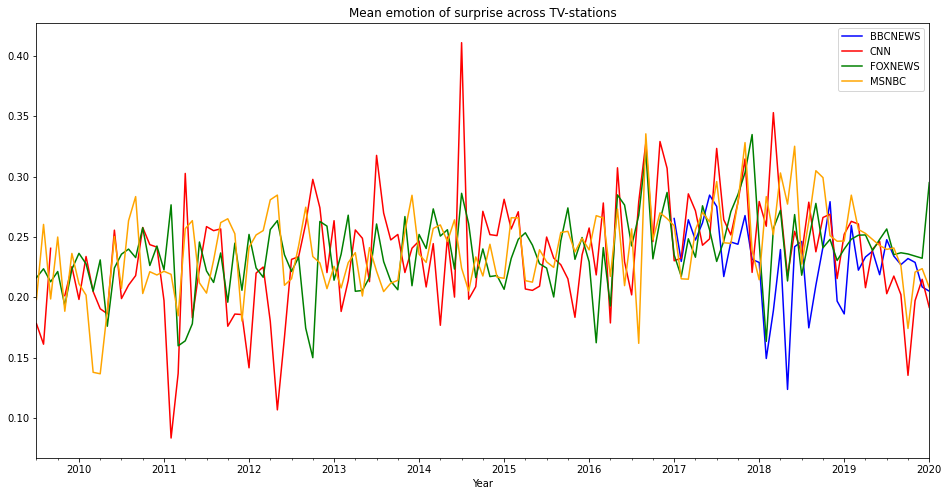

In [38]:
# surprise
df[df['station']=="BBCNEWS"].groupby(pd.Grouper(freq='M')).mean()['surprise'].plot(label="BBCNEWS", color="blue")
df[df['station']=="CNN"].groupby(pd.Grouper(freq='M')).mean()['surprise'].plot(label="CNN", color="red")
df[df['station']=="FOXNEWS"].groupby(pd.Grouper(freq='M')).mean()['surprise'].plot(label="FOXNEWS", color="green")
df[df['station']=="MSNBC"].groupby(pd.Grouper(freq='M')).mean()['surprise'].plot(label="MSNBC", color="orange")
plt.title("Mean emotion of surprise across TV-stations")
plt.xlabel('Year')
plt.legend()

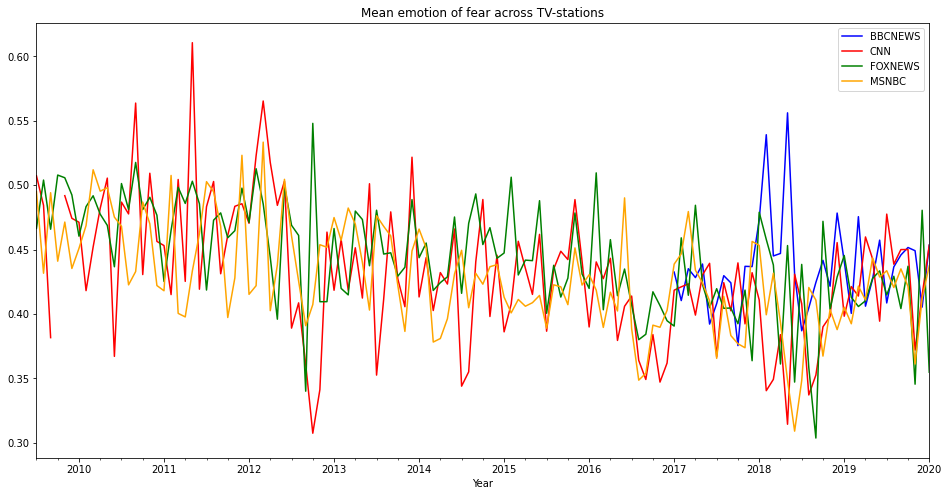

In [39]:
# fear
df[df['station']=="BBCNEWS"].groupby(pd.Grouper(freq='M')).mean()['fear'].plot(label="BBCNEWS", color="blue")
df[df['station']=="CNN"].groupby(pd.Grouper(freq='M')).mean()['fear'].plot(label="CNN", color="red")
df[df['station']=="FOXNEWS"].groupby(pd.Grouper(freq='M')).mean()['fear'].plot(label="FOXNEWS", color="green")
df[df['station']=="MSNBC"].groupby(pd.Grouper(freq='M')).mean()['fear'].plot(label="MSNBC", color="orange")
plt.title("Mean emotion of fear across TV-stations")
plt.xlabel('Year')
plt.legend()

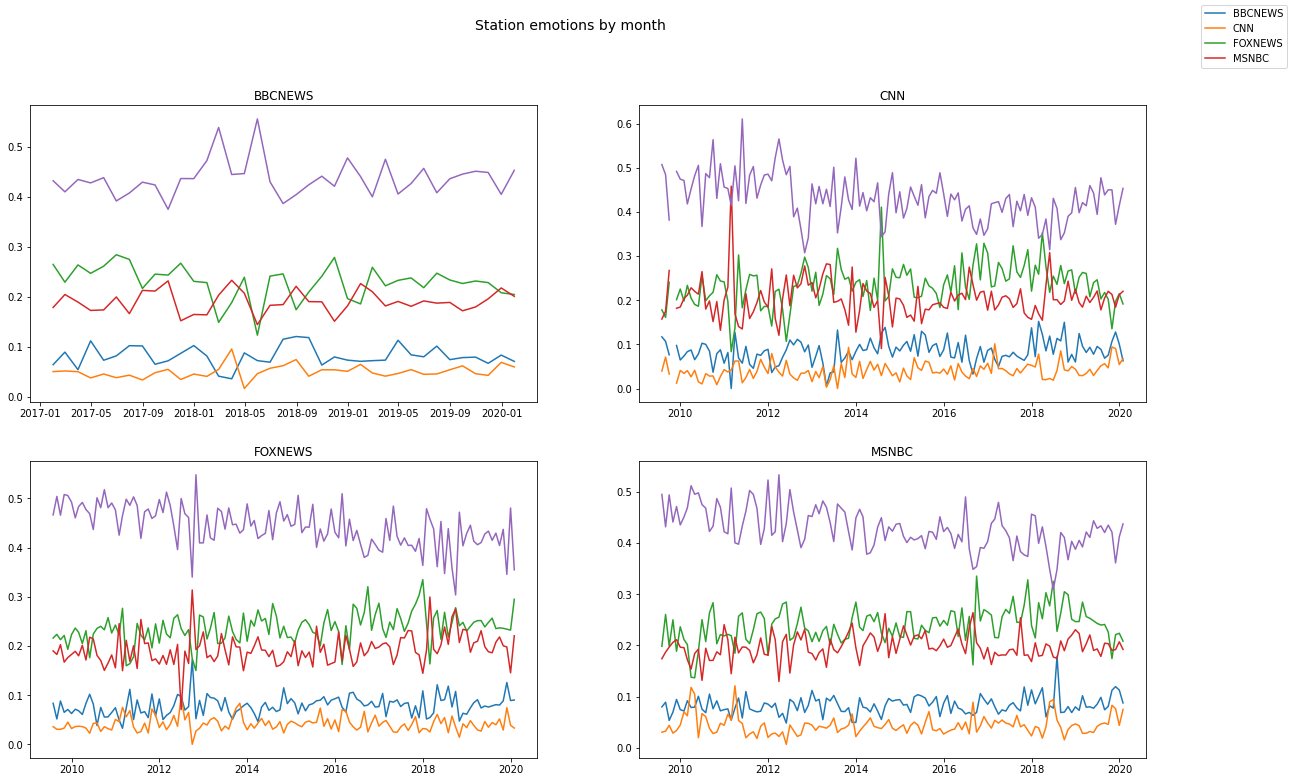

In [40]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(20, 12)
fig.suptitle("Station emotions by month", fontsize=14)
axs[0, 0].plot(df[df['station'] == 'BBCNEWS'].groupby(pd.Grouper(freq='M')).mean()[['happy', 'angry', 'surprise', 'sad', 'fear']])
axs[0, 0].set_title('BBCNEWS')
axs[0, 1].plot(df[df['station'] == 'CNN'].groupby(pd.Grouper(freq='M')).mean()[['happy', 'angry', 'surprise', 'sad', 'fear']])
axs[0, 1].set_title('CNN')
axs[1, 0].plot(df[df['station'] == 'FOXNEWS'].groupby(pd.Grouper(freq='M')).mean()[['happy', 'angry', 'surprise', 'sad', 'fear']])
axs[1, 0].set_title('FOXNEWS')
axs[1, 1].plot(df[df['station'] == 'MSNBC'].groupby(pd.Grouper(freq='M')).mean()[['happy', 'angry', 'surprise', 'sad', 'fear']])
axs[1, 1].set_title('MSNBC')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels)

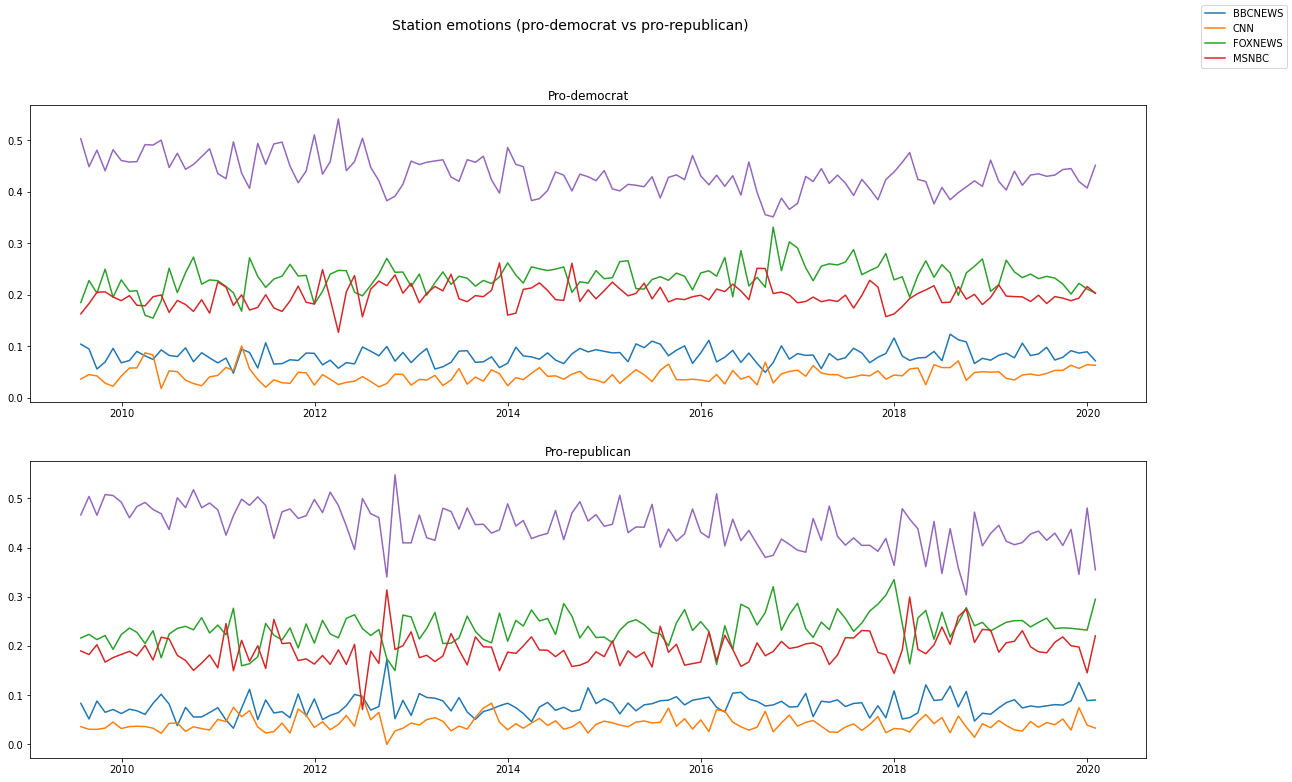

In [41]:
# grouping tv-shows based on if the audience is conservative or liberal
fig, axs = plt.subplots(2)
fig.set_size_inches(20, 12)
fig.suptitle("Station emotions (pro-democrat vs pro-republican)", fontsize=14)
axs[0].plot(df[df['station'] != 'FOXNEWS'].groupby(pd.Grouper(freq='M')).mean()[['happy', 'angry', 'surprise', 'sad', 'fear']])
axs[0].set_title('Pro-democrat')
axs[1].plot(df[df['station'] == 'FOXNEWS'].groupby(pd.Grouper(freq='M')).mean()[['happy', 'angry', 'surprise', 'sad', 'fear']])
axs[1].set_title('Pro-republican')
fig.legend(labels)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5dad1efb-9205-4e33-b917-077f54d8f326' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>